In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.chdir('/content/drive/MyDrive/FLIC')

In [3]:
!ls -la
!ls src/
!ls data/ | head -5

total 39
-rw-------  1 root root 17902 Dec 11 11:57 CLAUDE.md
drwx------ 28 root root  4096 Dec 11 12:52 data
-rw-------  1 root root  4673 Dec 11 11:57 enunciado.md
-rw-------  1 root root   287 Dec 11 11:57 .gitignore
drwx------  2 root root  4096 Dec 11 12:52 notebooks
-rw-------  1 root root  3025 Dec 11 11:57 README.md
-rw-------  1 root root   131 Dec 11 11:57 requirements.txt
drwx------  3 root root  4096 Dec 11 13:05 src
dataset.py   __init__.py  __pycache__  utils.py
evaluate.py  models.py	  train.py
Austria - Bundesliga
Belgium - Jupiler Pro League
Bulgaria - efbet Liga
Croatia - SuperSport HNL
Czech Republic - Chance Liga


In [4]:
!pip install -q torch torchvision matplotlib seaborn scikit-learn Pillow

In [5]:
import sys
sys.path.append('.')

import torch
import matplotlib.pyplot as plt

from src.dataset import get_dataloaders
from src.models import CustomCNN, get_resnet18
from src.train import train_model
from src.evaluate import evaluate_model, plot_confusion_matrix, plot_training_history
from src.utils import predict_from_dataset, visualize_prediction_from_dataset, visualize_dataset_samples

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


In [6]:
DATA_DIR = 'data'
BATCH_SIZE = 32

train_loader, val_loader, test_loader, class_names = get_dataloaders(
    DATA_DIR,
    batch_size=BATCH_SIZE,
    val_split=0.15,
    test_split=0.15
)

print(f"Number of classes (leagues): {len(class_names)}")
print(f"Training samples: {len(train_loader.dataset)}")
print(f"Validation samples: {len(val_loader.dataset)}")
print(f"Test samples: {len(test_loader.dataset)}")

Number of classes (leagues): 26
Training samples: 425
Validation samples: 90
Test samples: 90


In [7]:
print("Leagues in dataset:")
for i, league in enumerate(class_names, 1):
    print(f"{i:2d}. {league}")

Leagues in dataset:
 1. Austria - Bundesliga
 2. Belgium - Jupiler Pro League
 3. Bulgaria - efbet Liga
 4. Croatia - SuperSport HNL
 5. Czech Republic - Chance Liga
 6. Denmark - Superliga
 7. England - Premier League
 8. France - Ligue 1
 9. Germany - Bundesliga
10. Greece - Super League 1
11. Hungary - Nemzeti Bajnokság
12. Israel - Ligat ha'Al
13. Italy - Serie A
14. Netherlands - Eredivisie
15. Norway - Eliteserien
16. Poland - PKO BP Ekstraklasa
17. Portugal - Liga Portugal
18. Romania - SuperLiga
19. Russia - Premier Liga
20. Scotland - Scottish Premiership
21. Serbia - Super liga Srbije
22. Spain - LaLiga
23. Sweden - Allsvenskan
24. Switzerland - Super League
25. Türkiye - Süper Lig
26. Ukraine - Premier Liga


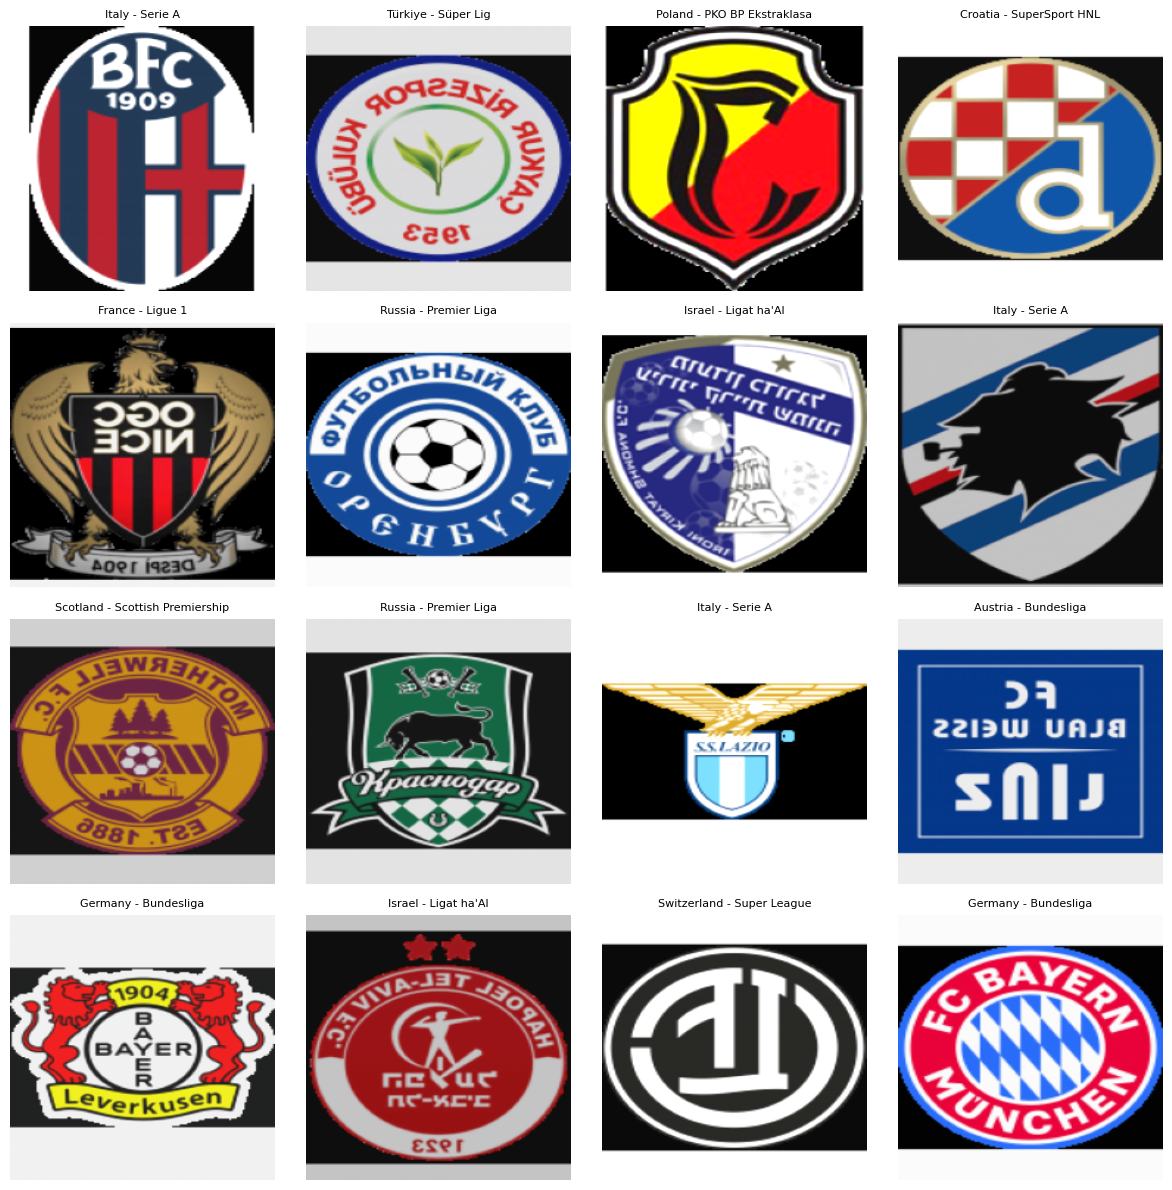

In [8]:
visualize_dataset_samples(train_loader.dataset.dataset, class_names, n_samples=16)

In [9]:
# ====================================================================
# SECTION 4: TRAIN CUSTOM CNN WITH MULTIPLE CONFIGURATIONS
# ====================================================================
# Probamos 3 configuraciones para encontrar la mejor combinación de epochs y lr
# Con dataset pequeño (605 imágenes), diferentes configs pueden tener resultados MUY distintos

# Configuraciones a probar para CustomCNN (entrena desde cero, sin conocimiento previo):
# Config 1 - AGRESIVA: lr alto, pocas epochs
#   - Aprende rápido pero puede "saltar" el mínimo óptimo
#   - Riesgo: overfitting temprano o inestabilidad
# Config 2 - BALANCEADA: lr medio, epochs medias
#   - Punto medio entre velocidad y estabilidad
#   - Esperamos mejor generalización
# Config 3 - CONSERVADORA: lr bajo, más epochs
#   - Aprende lento pero converge de forma más estable
#   - Menor riesgo de overfitting pero más tiempo de entrenamiento

cnn_configs = [
    {'name': 'Agresiva', 'epochs': 15, 'lr': 0.001},      # Rápida pero arriesgada
    {'name': 'Balanceada', 'epochs': 20, 'lr': 0.0005},   # Punto medio óptimo
    {'name': 'Conservadora', 'epochs': 25, 'lr': 0.0001}  # Lenta pero estable
]

# Guardaremos los resultados de cada configuración para compararlos
cnn_results = []

print("="*70)
print("CUSTOM CNN - PRUEBA DE CONFIGURACIONES")
print("="*70)

# Probamos cada configuración
for i, config in enumerate(cnn_configs, 1):
    print(f"\n{'='*70}")
    print(f"CONFIG {i}/3: {config['name']}")
    print(f"Epochs: {config['epochs']} | Learning Rate: {config['lr']}")
    print(f"{'='*70}")

    # Creamos un modelo nuevo para cada configuración (partimos desde cero cada vez)
    model = CustomCNN(num_classes=len(class_names))

    # Entrenamos con la configuración actual
    history = train_model(
        model,
        train_loader,
        val_loader,
        epochs=config['epochs'],
        lr=config['lr'],
        device=DEVICE
    )

    # Guardamos los resultados: modelo entrenado + métricas + configuración usada
    cnn_results.append({
        'config': config,
        'model': model,
        'history': history,
        'final_val_acc': history['val_acc'][-1],  # Accuracy final en validación
        'final_val_loss': history['val_loss'][-1],  # Loss final en validación
        'overfitting': history['train_acc'][-1] - history['val_acc'][-1]  # Gap train-val (cuanto mayor, más overfitting)
    })

    print(f"\nResultados Config {config['name']}:")
    print(f"  - Val Accuracy: {history['val_acc'][-1]:.2f}%")
    print(f"  - Val Loss: {history['val_loss'][-1]:.4f}")
    print(f"  - Overfitting (train_acc - val_acc): {history['train_acc'][-1] - history['val_acc'][-1]:.2f}%")

print(f"\n{'='*70}")
print("CUSTOM CNN - Configuraciones completadas")
print(f"{'='*70}")

CUSTOM CNN - PRUEBA DE CONFIGURACIONES

CONFIG 1/3: Agresiva
Epochs: 15 | Learning Rate: 0.001
Epoch 1/15:
  Train Loss: 4.1849 | Train Acc: 4.00%
  Val Loss: 3.2575 | Val Acc: 3.33%
Epoch 2/15:
  Train Loss: 3.2546 | Train Acc: 5.65%
  Val Loss: 3.2552 | Val Acc: 4.44%
Epoch 3/15:
  Train Loss: 3.2397 | Train Acc: 3.53%
  Val Loss: 3.2707 | Val Acc: 3.33%
Epoch 4/15:
  Train Loss: 3.1662 | Train Acc: 8.94%
  Val Loss: 3.1691 | Val Acc: 16.67%
Epoch 5/15:
  Train Loss: 2.9600 | Train Acc: 18.12%
  Val Loss: 3.1529 | Val Acc: 10.00%
Epoch 6/15:
  Train Loss: 2.6596 | Train Acc: 25.18%
  Val Loss: 3.0031 | Val Acc: 14.44%
Epoch 7/15:
  Train Loss: 2.1109 | Train Acc: 42.82%
  Val Loss: 3.2351 | Val Acc: 22.22%
Epoch 8/15:
  Train Loss: 1.6272 | Train Acc: 55.53%
  Val Loss: 3.4516 | Val Acc: 21.11%
Epoch 9/15:
  Train Loss: 1.0764 | Train Acc: 70.35%
  Val Loss: 3.9044 | Val Acc: 17.78%
Epoch 10/15:
  Train Loss: 0.9243 | Train Acc: 74.82%
  Val Loss: 4.1460 | Val Acc: 20.00%
Epoch 11/15

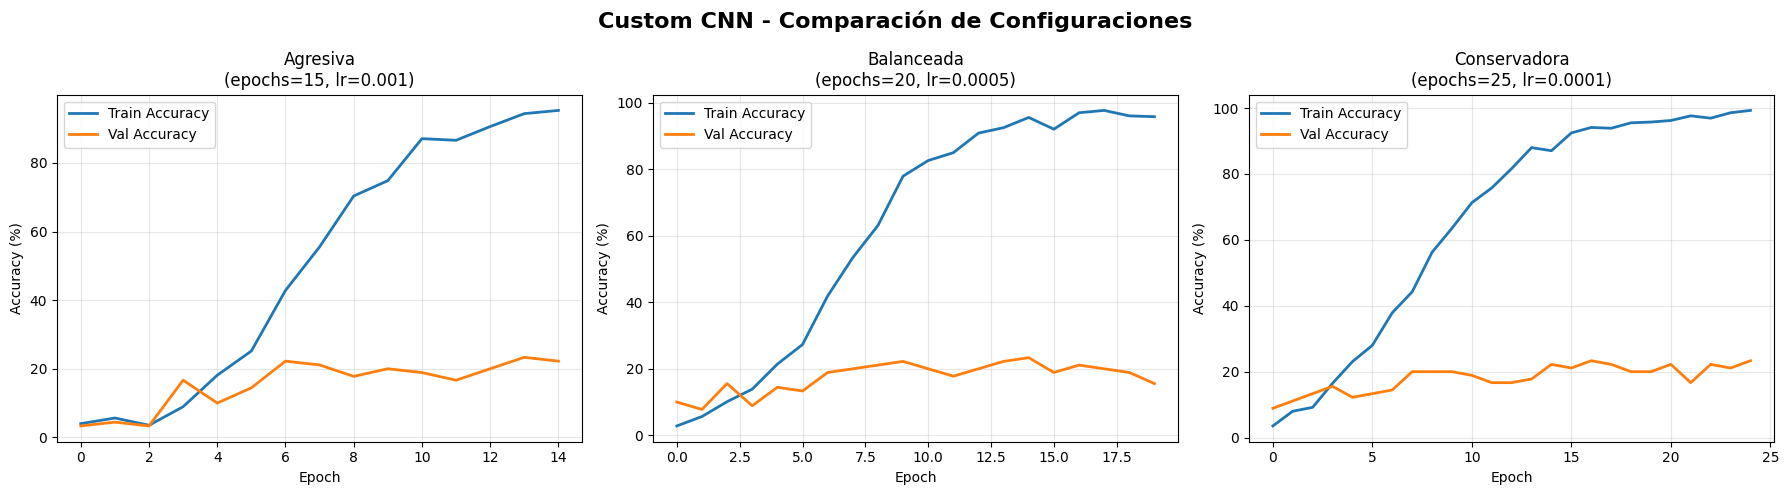

In [10]:
# Visualizamos el progreso de entrenamiento de cada configuración del CustomCNN
# Esto nos ayuda a identificar overfitting, underfitting, o convergencia óptima

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Custom CNN - Comparación de Configuraciones', fontsize=16, fontweight='bold')

for i, result in enumerate(cnn_results):
    ax = axes[i]
    history = result['history']
    config = result['config']

    # Plot de accuracy (train vs validation)
    ax.plot(history['train_acc'], label='Train Accuracy', linewidth=2)
    ax.plot(history['val_acc'], label='Val Accuracy', linewidth=2)
    ax.set_title(f"{config['name']}\n(epochs={config['epochs']}, lr={config['lr']})")
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy (%)')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [11]:
# Seleccionamos la mejor configuración del CustomCNN
# Criterio: Mayor val_accuracy + menor overfitting (diferencia entre train y val)
# No siempre la que mejor va en train es la mejor, puede estar overfitteando

best_cnn = max(cnn_results, key=lambda x: x['final_val_acc'] - 0.3 * x['overfitting'])
# Penalizamos overfitting con factor 0.3: preferimos modelo que generalice bien

print("="*70)
print("MEJOR CONFIGURACIÓN - CUSTOM CNN")
print("="*70)
print(f"Configuración elegida: {best_cnn['config']['name']}")
print(f"  - Epochs: {best_cnn['config']['epochs']}")
print(f"  - Learning Rate: {best_cnn['config']['lr']}")
print(f"  - Val Accuracy: {best_cnn['final_val_acc']:.2f}%")
print(f"  - Val Loss: {best_cnn['final_val_loss']:.4f}")
print(f"  - Overfitting: {best_cnn['overfitting']:.2f}%")
print("="*70)

MEJOR CONFIGURACIÓN - CUSTOM CNN
Configuración elegida: Conservadora
  - Epochs: 25
  - Learning Rate: 0.0001
  - Val Accuracy: 23.33%
  - Val Loss: 4.4237
  - Overfitting: 75.96%


In [12]:
# ====================================================================
# SECTION 5: TRAIN RESNET18 WITH MULTIPLE CONFIGURATIONS
# ====================================================================
# ResNet18 con transfer learning: YA sabe reconocer patrones de ImageNet (1M imágenes)
# Solo necesitamos ajustarlo a nuestras 26 ligas de fútbol

# Configuraciones para ResNet18 (transfer learning, pesos preentrenados):
# Config 1 - ESTÁNDAR: Configuración típica para transfer learning
#   - lr bajo (0.0001) para no destruir los pesos preentrenados de ImageNet
#   - Pocas epochs porque ya tiene conocimiento previo
# Config 2 - MODERADA: Más refinamiento
#   - lr más bajo y más epochs para ajuste más fino
# Config 3 - FINA: Máxima precisión
#   - lr muy bajo (0.00001) para ajustes mínimos sin romper lo aprendido
#   - Más epochs para convergencia lenta pero óptima

resnet_configs = [
    {'name': 'Estándar', 'epochs': 10, 'lr': 0.0001},    # Transfer learning clásico
    {'name': 'Moderada', 'epochs': 15, 'lr': 0.00005},   # Más refinamiento
    {'name': 'Fina', 'epochs': 20, 'lr': 0.00001}        # Ajuste ultra-fino
]

# Guardaremos los resultados de cada configuración
resnet_results = []

print("="*70)
print("RESNET18 (TRANSFER LEARNING) - PRUEBA DE CONFIGURACIONES")
print("="*70)

# Probamos cada configuración
for i, config in enumerate(resnet_configs, 1):
    print(f"\n{'='*70}")
    print(f"CONFIG {i}/3: {config['name']}")
    print(f"Epochs: {config['epochs']} | Learning Rate: {config['lr']}")
    print(f"{'='*70}")

    # Creamos un modelo ResNet18 con pesos de ImageNet
    model = get_resnet18(num_classes=len(class_names), pretrained=True)

    # Entrenamos (fine-tuning: ajustamos los pesos preentrenados a nuestro problema)
    history = train_model(
        model,
        train_loader,
        val_loader,
        epochs=config['epochs'],
        lr=config['lr'],
        device=DEVICE
    )

    # Guardamos resultados
    resnet_results.append({
        'config': config,
        'model': model,
        'history': history,
        'final_val_acc': history['val_acc'][-1],
        'final_val_loss': history['val_loss'][-1],
        'overfitting': history['train_acc'][-1] - history['val_acc'][-1]
    })

    print(f"\nResultados Config {config['name']}:")
    print(f"  - Val Accuracy: {history['val_acc'][-1]:.2f}%")
    print(f"  - Val Loss: {history['val_loss'][-1]:.4f}")
    print(f"  - Overfitting (train_acc - val_acc): {history['train_acc'][-1] - history['val_acc'][-1]:.2f}%")

print(f"\n{'='*70}")
print("RESNET18 - Configuraciones completadas")
print(f"{'='*70}")

RESNET18 (TRANSFER LEARNING) - PRUEBA DE CONFIGURACIONES

CONFIG 1/3: Estándar
Epochs: 10 | Learning Rate: 0.0001
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 44.7M/44.7M [00:00<00:00, 215MB/s]


Epoch 1/10:
  Train Loss: 3.2820 | Train Acc: 8.94%
  Val Loss: 3.0693 | Val Acc: 17.78%
Epoch 2/10:
  Train Loss: 2.0864 | Train Acc: 60.00%
  Val Loss: 2.9345 | Val Acc: 25.56%
Epoch 3/10:
  Train Loss: 1.4556 | Train Acc: 87.06%
  Val Loss: 2.8746 | Val Acc: 22.22%
Epoch 4/10:
  Train Loss: 0.9646 | Train Acc: 96.00%
  Val Loss: 2.7873 | Val Acc: 23.33%
Epoch 5/10:
  Train Loss: 0.6199 | Train Acc: 99.76%
  Val Loss: 2.7581 | Val Acc: 24.44%
Epoch 6/10:
  Train Loss: 0.4145 | Train Acc: 99.53%
  Val Loss: 2.7348 | Val Acc: 24.44%
Epoch 7/10:
  Train Loss: 0.2788 | Train Acc: 100.00%
  Val Loss: 2.7643 | Val Acc: 25.56%
Epoch 8/10:
  Train Loss: 0.1776 | Train Acc: 100.00%
  Val Loss: 2.7367 | Val Acc: 24.44%
Epoch 9/10:
  Train Loss: 0.1361 | Train Acc: 100.00%
  Val Loss: 2.7803 | Val Acc: 23.33%
Epoch 10/10:
  Train Loss: 0.1057 | Train Acc: 100.00%
  Val Loss: 2.7805 | Val Acc: 25.56%

Resultados Config Estándar:
  - Val Accuracy: 25.56%
  - Val Loss: 2.7805
  - Overfitting (trai

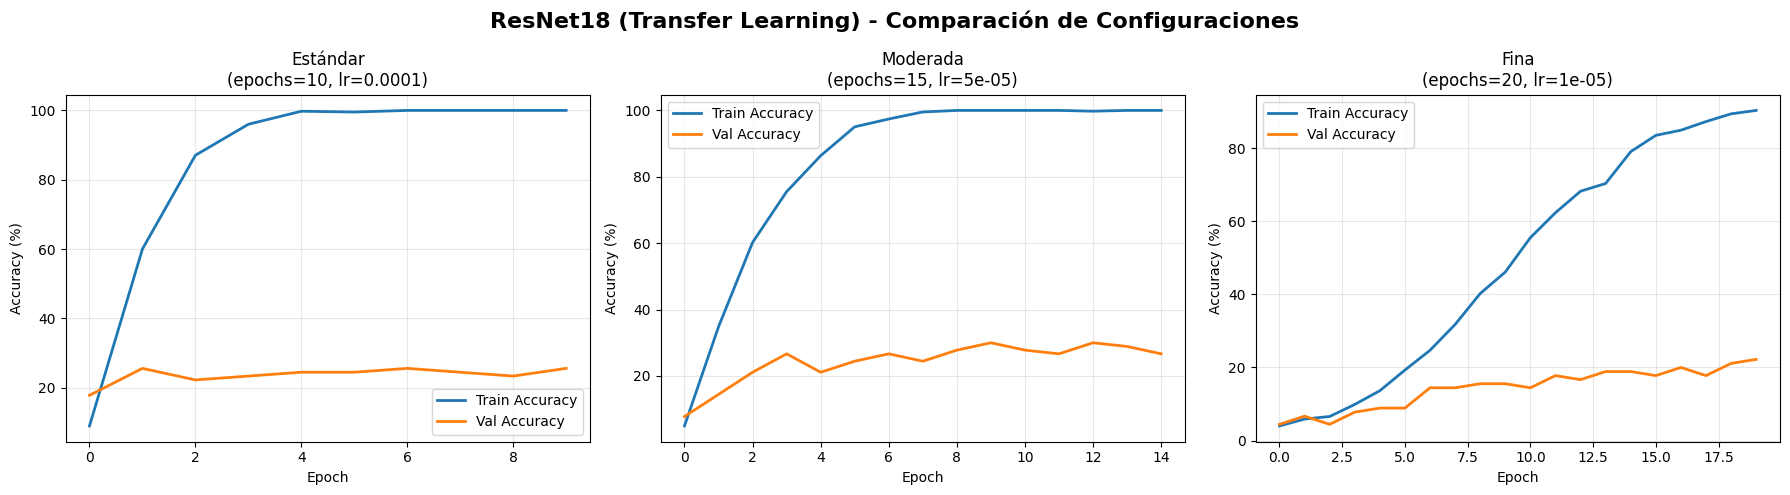

In [13]:
# Visualizamos el progreso de entrenamiento de cada configuración del ResNet18
# Transfer learning suele converger más rápido que entrenar desde cero

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('ResNet18 (Transfer Learning) - Comparación de Configuraciones', fontsize=16, fontweight='bold')

for i, result in enumerate(resnet_results):
    ax = axes[i]
    history = result['history']
    config = result['config']

    # Plot de accuracy (train vs validation)
    ax.plot(history['train_acc'], label='Train Accuracy', linewidth=2)
    ax.plot(history['val_acc'], label='Val Accuracy', linewidth=2)
    ax.set_title(f"{config['name']}\n(epochs={config['epochs']}, lr={config['lr']})")
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy (%)')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [14]:
# Seleccionamos la mejor configuración del ResNet18
# Mismo criterio: Mayor val_accuracy + menor overfitting

best_resnet = max(resnet_results, key=lambda x: x['final_val_acc'] - 0.3 * x['overfitting'])

print("="*70)
print("MEJOR CONFIGURACIÓN - RESNET18")
print("="*70)
print(f"Configuración elegida: {best_resnet['config']['name']}")
print(f"  - Epochs: {best_resnet['config']['epochs']}")
print(f"  - Learning Rate: {best_resnet['config']['lr']}")
print(f"  - Val Accuracy: {best_resnet['final_val_acc']:.2f}%")
print(f"  - Val Loss: {best_resnet['final_val_loss']:.4f}")
print(f"  - Overfitting: {best_resnet['overfitting']:.2f}%")
print("="*70)

MEJOR CONFIGURACIÓN - RESNET18
Configuración elegida: Moderada
  - Epochs: 15
  - Learning Rate: 5e-05
  - Val Accuracy: 26.67%
  - Val Loss: 2.6991
  - Overfitting: 73.33%


In [15]:
# ====================================================================
# SECTION 6: EVALUATE MODELS ON TEST SET
# ====================================================================
# Evaluamos los mejores modelos seleccionados en el test set (datos nunca vistos)
# Métricas: accuracy, precision, recall, F1-score por cada liga

print("="*70)
print("EVALUACIÓN: MEJOR CUSTOM CNN")
print("="*70)
results_cnn = evaluate_model(best_cnn['model'], test_loader, class_names, device=DEVICE)

EVALUACIÓN: MEJOR CUSTOM CNN
Test Accuracy: 14.44%

Classification Report:
                                 precision    recall  f1-score   support

           Austria - Bundesliga       0.00      0.00      0.00         2
   Belgium - Jupiler Pro League       0.33      0.50      0.40         2
          Bulgaria - efbet Liga       0.00      0.00      0.00         4
       Croatia - SuperSport HNL       1.00      0.50      0.67         2
   Czech Republic - Chance Liga       0.33      0.50      0.40         2
            Denmark - Superliga       0.33      0.33      0.33         3
       England - Premier League       0.33      0.22      0.27         9
               France - Ligue 1       0.33      0.14      0.20         7
           Germany - Bundesliga       0.00      0.00      0.00         2
        Greece - Super League 1       0.00      0.00      0.00         3
   Hungary - Nemzeti Bajnokság       0.00      0.00      0.00         3
           Israel - Ligat ha'Al       0.00      

In [16]:
print("\n" + "="*70)
print("EVALUACIÓN: MEJOR RESNET18")
print("="*70)
results_resnet = evaluate_model(best_resnet['model'], test_loader, class_names, device=DEVICE)


EVALUACIÓN: MEJOR RESNET18
Test Accuracy: 27.78%

Classification Report:
                                 precision    recall  f1-score   support

           Austria - Bundesliga       1.00      0.50      0.67         2
   Belgium - Jupiler Pro League       0.14      0.50      0.22         2
          Bulgaria - efbet Liga       0.00      0.00      0.00         4
       Croatia - SuperSport HNL       1.00      0.50      0.67         2
   Czech Republic - Chance Liga       0.17      0.50      0.25         2
            Denmark - Superliga       0.50      0.33      0.40         3
       England - Premier League       0.33      0.11      0.17         9
               France - Ligue 1       1.00      0.14      0.25         7
           Germany - Bundesliga       0.00      0.00      0.00         2
        Greece - Super League 1       0.14      0.33      0.20         3
   Hungary - Nemzeti Bajnokság       0.00      0.00      0.00         3
           Israel - Ligat ha'Al       1.00      0

In [17]:
# ====================================================================
# SECTION 7: FINAL COMPARISON
# ====================================================================
# Comparamos ambos modelos y determinamos el ganador final

print("\n" + "="*70)
print("COMPARACIÓN FINAL - TEST SET")
print("="*70)
print(f"Custom CNN ({best_cnn['config']['name']}): {results_cnn['accuracy']:.2f}%")
print(f"ResNet18 ({best_resnet['config']['name']}): {results_resnet['accuracy']:.2f}%")
print(f"\nMejora con Transfer Learning: {results_resnet['accuracy'] - results_cnn['accuracy']:.2f}%")
print("="*70)

# Seleccionamos el modelo ganador (mayor accuracy en test)
if results_resnet['accuracy'] > results_cnn['accuracy']:
    winner_name = f"ResNet18 ({best_resnet['config']['name']})"
    winner_model = best_resnet['model']
    winner_results = results_resnet
else:
    winner_name = f"Custom CNN ({best_cnn['config']['name']})"
    winner_model = best_cnn['model']
    winner_results = results_cnn

print(f"\nMODELO GANADOR: {winner_name}")
print(f"Test Accuracy: {winner_results['accuracy']:.2f}%")


COMPARACIÓN FINAL - TEST SET
Custom CNN (Conservadora): 14.44%
ResNet18 (Moderada): 27.78%

Mejora con Transfer Learning: 13.33%

MODELO GANADOR: ResNet18 (Moderada)
Test Accuracy: 27.78%


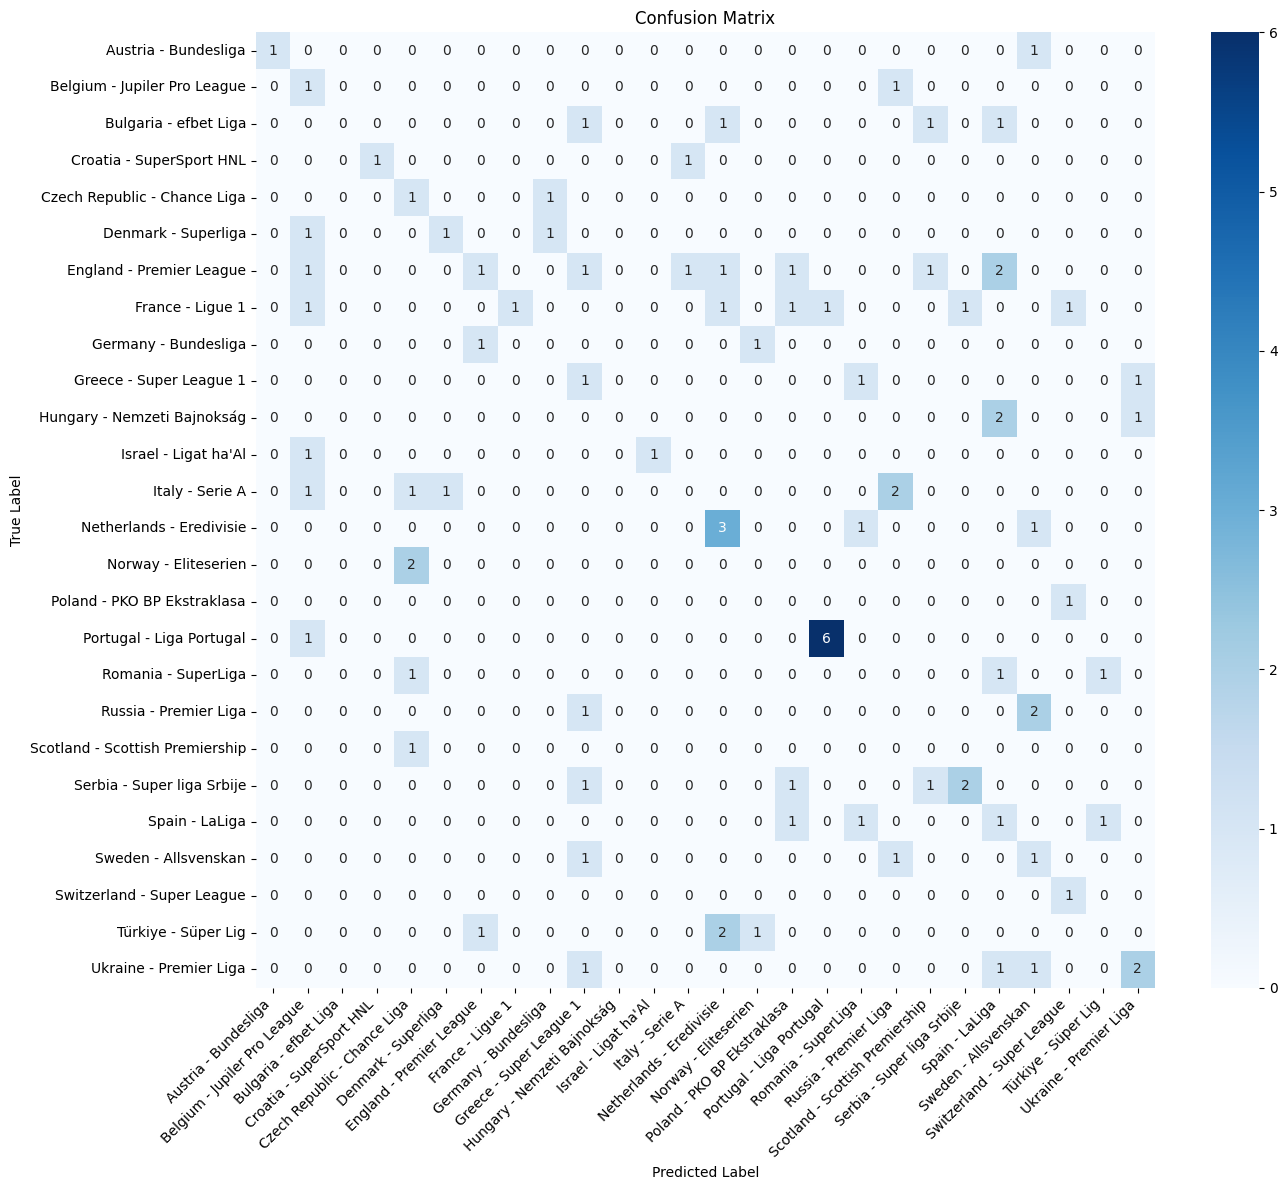

In [18]:
# ====================================================================
# SECTION 8: CONFUSION MATRIX
# ====================================================================
# Matriz de confusión del modelo ganador
# Muestra dónde el modelo se confunde: qué ligas clasifica mal y con qué las confunde

plot_confusion_matrix(
    winner_results['labels'],
    winner_results['predictions'],
    class_names,
    figsize=(14, 12)
)

In [19]:
# ====================================================================
# SECTION 9: TEST PREDICTIONS
# ====================================================================
# Probamos el modelo ganador con una imagen aleatoria del test set
# Vemos las top-5 predicciones con sus probabilidades

import random

# Dataset de test (sin transformaciones de augmentation, solo normalización)
test_dataset = test_loader.dataset.dataset

# Seleccionamos una imagen aleatoria
random_idx = random.randint(0, len(test_dataset) - 1)

# Hacemos predicción con el modelo ganador
predictions, true_label, image = predict_from_dataset(
    test_dataset,
    winner_model,
    class_names,
    random_idx,
    device=DEVICE,
    top_k=5
)

print(f"True Label: {true_label}")
print("\nTop 5 predictions:")
for i, (league, prob) in enumerate(predictions, 1):
    print(f"{i}. {league}: {prob:.2f}%")

True Label: Czech Republic - Chance Liga

Top 5 predictions:
1. Germany - Bundesliga: 22.18%
2. Norway - Eliteserien: 10.15%
3. Switzerland - Super League: 8.71%
4. Spain - LaLiga: 6.08%
5. Poland - PKO BP Ekstraklasa: 5.33%


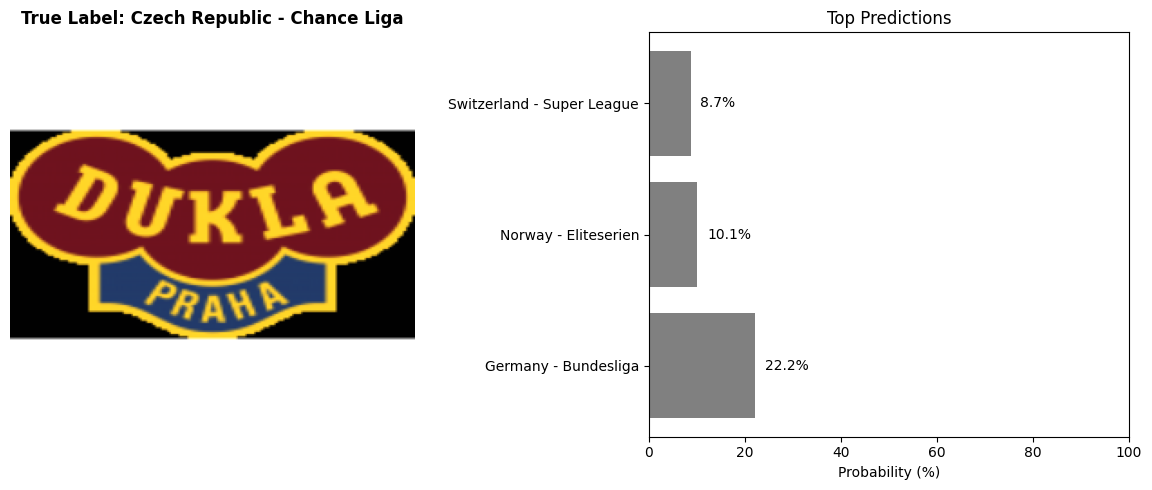

In [20]:
# Visualizamos la predicción (imagen + top 3 predicciones + etiqueta real)
visualize_prediction_from_dataset(image, predictions[:3], true_label)

In [21]:
# ====================================================================
# SECTION 10: SAVE BEST MODEL
# ====================================================================
# Guardamos el modelo ganador para uso futuro

import os
os.makedirs('models', exist_ok=True)

MODEL_PATH = 'models/best_model.pth'
torch.save(winner_model.state_dict(), MODEL_PATH)

print("="*70)
print("MODELO GUARDADO")
print("="*70)
print(f"Modelo: {winner_name}")
print(f"Path: {MODEL_PATH}")
print(f"Test Accuracy: {winner_results['accuracy']:.2f}%")
print("="*70)

MODELO GUARDADO
Modelo: ResNet18 (Moderada)
Path: models/best_model.pth
Test Accuracy: 27.78%
